# Treść zadania

1. Zaimplementować semafor binarny za pomocą metod `wait` i `notify`, użyć go do synchronizacji programu *Wyścig*

2. Pokazać, że do implementacji semafora za pomocą metod `wait` i `notify` nie wystarczy instrukcja `if` tylko potrzeba użyć `while`. Wyjaśnić teoretycznie dlaczego i potwierdzić eksperymentem w praktyce. (wskazówka: rozważyć dwie kolejki: czekającą na wejście do monitora obiektu oraz kolejkę związaną z instrukcją `wait`, rozważyć kto kiedy jest budzony i kiedy następuje wyścig).

3. Zaimplementować semafor licznikowy (ogólny) za pomocą semaforów binarnych. Czy semafor binarny jest szczególnym przypadkiem semafora ogólnego?

# Rozwiązanie

Najpierw warto przypomnieć, że program *wyścig* polegał na tym, że mamy licznik, który
jest modyfikowany przez dwa wątki: pierwszy zwiększa licznik o `1`, drugi zmniejsza o `1`.
Race condition (wyścig) wynika wtedy, gdy oba wątki próbują jednocześnie zmienić wartość
licznika. Jako wynik, dostajemy na wyjściu wartość, która różni się od oczekiwanej, tzn. `0`.

W celach synchronizacji dostępu do licznika, tym razem skorzystamy z semafora binarnego,
czyli takiego, który ma tylko 2 stany: albo jest zablokowany przez któryś wątek, albo odblokowany.

Chcąc zaimplementować taki mechanizm synchronizujący, użyjemy Javowych monitorów, w tym celu
będziemy korzystali z metod `Object#wait` i `Object#notify`. Dodatkowo, zostanie wykorzystane
słowo kluczowe `synchronized`.

Odwołamy się do dokumentacji (Java 17):

> `Object#wait`:
> Causes the current thread to wait until it is awakened, typically by being *notified* or *interrupted*.
> [...]
> **This method causes the current thread** (referred to here as T) to place itself in the wait set for this
> object and then **to relinquish any and all synchronization claims on this object**. Note that only the
> locks on this object are relinquished; any other objects on which the current thread may be synchronized
> remain locked while the thread waits. 

> `Object#notify`:
> Wakes up a single thread that is waiting on this object's monitor.
> [...]
>  This method should only be called by a thread that is the owner of this object's monitor. A thread becomes
> the owner of the object's monitor in one of three ways:
> 
> - By executing a synchronized instance method of that object.
> - By executing the body of a synchronized statement that synchronizes on the object.
> - For objects of type Class, by executing a synchronized static method of that class. 
> 
> Only one thread at a time can own an object's monitor.

Z tego wynika, że:

- `Object#wait`
  - Może być wywołana tylko przez wątek będący w posiadaniu monitora
  - Powoduje uśpienie wątku w kolejce związanej z monitorem
  - **Zwalnia monitor**
  - Wątek może być obudzony gdy inny wątek wywoła `notify`, albo gdy wątek zostanie przerwany (interrupted)
- `Object#notify`
  - Budzi jeden wątek spośród oczekujących w kolejce 'wait'
  - Obudzony wątek oczekuje aż wątek wywołujący `notify` zwolni monitor
  - Żeby poprawnie wywołać tę metodę, musi zostać spełniony co najmniej jeden z trzech warunków:
    1. Metoda została wywołana z zsynchronizowanej metody danego obiektu (synchronized method)
    2. Metoda została wywołana z zsynchronizowanego bloku danego obiektu
    3. Dla obiektów typu `Class`, poprzez wykonanie zsynchronizowanej metody statycznej tej klasy

## Semafor binarny (punkt 1)

Poniżej została przedstawiona implementacja semafora binarnego.

```java
// Semafor.java

package pl.edu.agh.tw.knapp;

class Semafor implements ISemaphore {
    private boolean _stan = true;
    private int _czeka = 0;

    public Semafor() {
    }

    @Override
    public synchronized void P() {
        ++_czeka;

        while (!_stan) {
            try {
                wait();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }
        }

        _stan = false;
        --_czeka;
    }

    @Override
    public synchronized void V() {
        _stan = true;

        if (_czeka > 0) {
            notify();
        }
    }
}
```

Dostępne operacje na tym semaforze:

- Opuszczenie, `Semafor#P`: Jeśli `S == 1` to `S = 0`, w przeciwnym wypadku wstrzymaj działanie procesu
  wykonującego tę operację
- Podniesienie, `Semafor#V`: Jeśli są procesy wstrzymane w wyniku opuszczania semafora `S`, to wznów
  jeden z nich, w przeciwnym razie `S = 1`

## `if` a `while` (punkt 2)

Do implementacji semafora za pomocą metod `wait` i `notify` nie wystarczy instrukcji `if`, trzeba użyć
`while`. To wynika z kilku powodów, a mianowicie:

1. Spurious wakeup (Fałszywe obudzenie) - wątek może zostać obudzony nie przez inny wątek, lecz przez
   system. W takim przypadku warunek, na który czeka wątek, może nie zostać spełniony. W celu zapobiegania
   takiej sytuacji, po obudzeniu wątek musi sprawdzić, czy warunek został rzeczywiście spełniony;

2. Zgodnie z dokumentacją, metoda `wait` zwalnia monitor. To znaczy, że inny wątek `A` może spróbować
   zablokować dany semafor. Biorąc pod uwagę fakt, iż obudzenie wątku `B` nie następuje natychmiast,
   semafor może zostać zablokowany przez wątek `A`. Uwzględniając to, że została użyta instrukcja `if`,
   wątek `B` również zablokuje semafor (tu już mamy do czynienia z undefined behavior - synchronizacja
   nie zadziałała poprawnie):

   ```
   Wątek A      Wątek B
   P
   ***          P
   ***          ...
   V            ...
   P            obudzenie się zaczęło
   ***          wątek został obudzony
   ***          ***
   ==================================
       BŁĄD: oba wątki mają dostęp
         do tego samego zasobu
             jednocześnie
   ==================================
   ```

   Gdzie `***` - wykonanie jakiejś pracy przez wątek, `...` - czekanie na zwolnienie semafora.

> Uwaga: eksperymentalne potwierdzenie znajduje się w rozdziale *Wyniki*.

## Semafor licznikowy (punkt 3)

Semafor licznikowy jest uogólnieniem semafora binarnego. Ten mechanizm synchronizacji może zostać
zaimplementowany na kilka sposobów, między innymi:

- Z wykorzystaniem semaforów binarnych
- Z wykorzystaniem metod `wait`, `notify` i słowa kluczowego `synchronized`

### I sposób

Ten sposób przedstawia implementację semafora licznikowego z wykorzystaniem 2 semaforów binarnych:
pierwszy jest potrzebny do synchronizacji licznika, drugi do uśpienia czekającego wątku.

```java
// CountingSemaphore.java

package pl.edu.agh.tw.knapp;

public class CountingSemaphore implements ISemaphore {
    private final Semafor threadLocker = new Semafor();
    private final Semafor counterLocker = new Semafor();

    private int counter;

    public CountingSemaphore(int initialValue) {
        counter = initialValue;
    }

    @Override
    public void P() {
        counterLocker.P();

        if (counter > 0) {
            --counter;
            counterLocker.V();
        } else {
            counterLocker.V();
            threadLocker.P();
            P();
        }
    }

    @Override
    public void V() {
        counterLocker.P();

        if (++counter == 1) {
            threadLocker.V();
        }

        counterLocker.V();
    }
}
```

Jak widać, implementacja jest prosta, lecz w przypadku Javy małoefektywna: klasa `Semafor`
ma swój własny mechanizm synchronizacji który jest oparty na metodach zsynchronizowanych, a także
`wait` i `notify`.

### II sposób

Ten sposób przedstawia efektywną implementację semafora licznikowego (ogólnego) nie korzystając z
wcześniej zaimplementowanego semafora binarnego. Poniższa implementacja w sposób oczywisty pokazuje,
iż semafor binarny jest tylko szczególnym przypadkiem semafora licznikowego (jest to semafor licznikowy
z wartością początkową równą `1`).

```java
// Semaphore.java

package pl.edu.agh.tw.knapp;

public class Semaphore implements ISemaphore {
    private int value;

    public Semaphore(int initialValue) {
        value = initialValue;
    }

    @Override
    public synchronized void P() {
        while (value == 0) {
            try {
                wait();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }
        }

        --value;
    }

    @Override
    public synchronized void V() {
        ++value;

        if (value == 1) {
            notify();
        }
    }
}
```

W porównaniu z poprzednim sposobem, ta implementacja jest krótsza, prostsza do zrozumienia
i, w sposób oczywisty, wydajniejsza.

# Wyniki

Wyniki zostały uzyskane poprzez uruchomienie programu `100` razy, następnie pobrane za pomocą
poniższego `bash` skryptu i przetworzone z wykorzystaniem języka `python`.

```bash
for _ in {1..100}
do
    ./gradlew run | sed -n 's/^.*stan=\s*\(\S*\).*$/\1/p'
done
```

## Semafor binarny

W tym rozdziale pokażę, że instrukcji `if` nie wystarczy do implementacji semafora.

### Instrukcja `if`

Modyfikuję klasę `Semafor` w następujący sposób:

```java
// Semafor.java

package pl.edu.agh.tw.knapp;

class Semafor {
    // ...

    public synchronized void P() {
        ++_czeka;

        if (!_stan) {
            try {
                wait();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }
        }

        _stan = false;
        --_czeka;
    }

    // ...
}
```

Po uruchomieniu uzyskuję wyniki i zapisuję je do pliku `semafor_if.txt`, następnie przetwarzam:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df_if = pd.read_csv("semafor_if.txt", header=None) 

print(df_if)

    0
0  -3
1  -1
2   0
3   0
4   1
.. ..
95  0
96 -2
97  0
98 -5
99  1

[100 rows x 1 columns]


array([[<Axes: title={'center': '0'}>]], dtype=object)

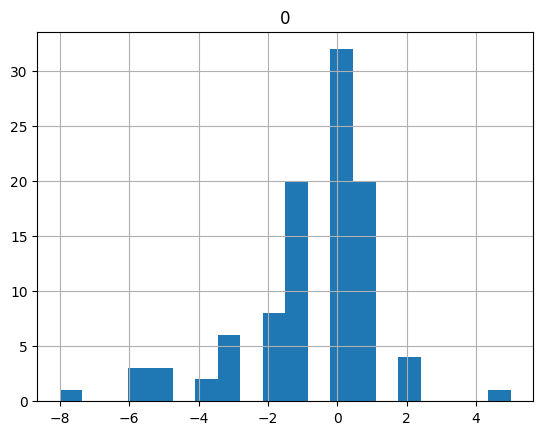

In [3]:
df_if.hist(bins=20)

Jak widać z tego histogramu, wartości nie są aż tak porozrzucane jak w przypadku całkowitego
braku synchronizacji (laboratorium 1), ale można stwierdzić, że mechanizm synchronizacji nie
działa poprawnie. W przypadku poprawnego działania musielibyśmy zobaczyć same zera.

### Instrukcja `while`

Modyfikuję klasę `Semafor` w następujący sposób:

```java
// Semafor.java

package pl.edu.agh.tw.knapp;

class Semafor {
    // ...

    public synchronized void P() {
        ++_czeka;

        while (!_stan) {
            try {
                wait();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }
        }

        _stan = false;
        --_czeka;
    }

    // ...
}
```

Po uruchomieniu uzyskuję wyniki i zapisuję je do pliku `semafor_while.txt`, następnie przetwarzam:

In [4]:
df_while = pd.read_csv("semafor_while.txt", header=None) 
print(df_while)

    0
0   0
1   0
2   0
3   0
4   0
.. ..
95  0
96  0
97  0
98  0
99  0

[100 rows x 1 columns]


In [5]:
df_while[df_while == 0]

,0
0,0
1,0
2,0
3,0
4,0
...,...
95,0
96,0
97,0
98,0


Jak widać z powyższego wyniku, wszystkie `100` wartości są równe `0`, a więc semafor działa
poprawnie.

## Semafor licznikowy

Poniżej został przetestowany semafor licznikowy jako semafor binarny.

W celach lepszego zrozumienia, warto dodać, że klasa zsynchronizowanego licznika wygląda następująco:

```java
// SynchronizedCounter.java

package pl.edu.agh.tw.knapp;

public class SynchronizedCounter extends Counter {
    private final ISemaphore semaphore;

    public SynchronizedCounter(int n, ISemaphore semaphore) {
        super(n);
        this.semaphore = semaphore;
    }

    @Override
    public void inc() {
        semaphore.P();
        super.inc();
        semaphore.V();
    }

    @Override
    public void dec() {
        semaphore.P();
        super.dec();
        semaphore.V();
    }
}
```

gdzie `ISemaphore` - interfejs, reprezentujący semafor:

```java
// ISemaphore.java

package pl.edu.agh.tw.knapp;

public interface ISemaphore {
    void P();
    void V();
}
```

### Semafor licznikowy zaimplementowany za pomocą semaforów binarnych

Zsynchronizowany licznik jest tworzony w następujący sposób:

```java
var counter = new SynchronizedCounter(0, new CountingSemaphore(1));
```

Po uruchomieniu uzyskuję wyniki i zapisuję je do pliku `counting_semaphore.txt`, następnie przetwarzam:

In [6]:
df_counting = pd.read_csv("counting_semaphore.txt", header=None) 
print(df_counting)

    0
0   0
1   0
2   0
3   0
4   0
.. ..
95  0
96  0
97  0
98  0
99  0

[100 rows x 1 columns]


In [7]:
df_counting[df_counting == 0]

,0
0,0
1,0
2,0
3,0
4,0
...,...
95,0
96,0
97,0
98,0


Mechanizm synchronizacji działa poprawnie - na wyjściu mamy same zera.

### Semafor licznikowy ogólny

W tym rozdziale zostały zareprezentowane wyniki działania semafora ogólnego, zaimplementowanego
bez korzystania z semaforów binarnych.

Zsynchronizowany licznik jest tworzony w następujący sposób:

```java
var counter = new SynchronizedCounter(0, new Semaphore(1));
```

Po uruchomieniu uzyskuję wyniki i zapisuję je do pliku `semaphore.txt`, następnie przetwarzam:

In [8]:
df_generalized = pd.read_csv("semaphore.txt", header=None) 
print(df_generalized)

    0
0   0
1   0
2   0
3   0
4   0
.. ..
95  0
96  0
97  0
98  0
99  0

[100 rows x 1 columns]


In [9]:
df_generalized[df_generalized == 0]

,0
0,0
1,0
2,0
3,0
4,0
...,...
95,0
96,0
97,0
98,0


Mechanizm synchronizacji działa poprawnie - na wyjściu mamy same zera.

# Wnioski

- Monitory w Javie synchronizują dostęp do metod i bloków synchronized i są związane z każdym
  obiektem
- Metod `wait`, `notify` / `notifyAll` można używać do synchronizacji działania wielu wątków
- Semafor binarny da się zaimplementować za pomoca metod `wait` i `notify` i słowa kluczowego
  `synchronized`
- Do implementacji semafora za pomocą metod `wait` i `notify` nie wystarczy instrukcji `if`,
  trzeba użyć instrukcji `while`
- Semafor licznikowy jest semaforem ogólnym - semafor binarny jest szczególnym przypadkiem
  semafora licznikowego (jest to semafor licznikowy z wartością początkową `1`)
- Semafor licznikowy da się zaimplementować korzystając tylko z semaforów binarnych, choć nie
  w bardzo wydajny sposób

# Bibliografia

1. [Materiały do laboratorium](https://home.agh.edu.pl/~funika/tw/lab2/)
2. [Java 17 Docs - Object](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/lang/Object.html)
3. [Wikipedia - Spurious wakeup](https://en.wikipedia.org/wiki/Spurious_wakeup)